In [1]:
import json
import bz2
from joblib import load

import torch
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

/sciclone/home/stmorse/.conda/envs/torch-tik-env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# test if CUDA enabled
torch.cuda.is_available()

False

In [3]:
path = '/sciclone/data10/twford/reddit/reddit/'

In [4]:
# this will store all JSON objects
res = []

# yrs and dates to search
# yrs = [2006, 2007]
yrs = [2006]
mos = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# loop through all years and months
for yr in yrs:
    for mo in mos:
        filename = f'RC_{yr}-{mo}.bz2'
        print(f'{filename}...')
        with bz2.BZ2File(path + 'comments/' + filename, 'rb') as file:
            for line in file:
                if len(line) < 10:
                    continue
                res.append(json.loads(line))

RC_2006-01.bz2...
RC_2006-02.bz2...
RC_2006-03.bz2...
RC_2006-04.bz2...
RC_2006-05.bz2...
RC_2006-06.bz2...
RC_2006-07.bz2...
RC_2006-08.bz2...
RC_2006-09.bz2...
RC_2006-10.bz2...
RC_2006-11.bz2...
RC_2006-12.bz2...


In [6]:
res[-1]

{'author_flair_css_class': None,
 'created_utc': 1167609532,
 'score': 1,
 'ups': 1,
 'subreddit': 'reddit.com',
 'link_id': 't3_wl3p',
 'stickied': False,
 'subreddit_id': 't5_6',
 'controversiality': 0,
 'body': 'Awsome strategy game!1',
 'retrieved_on': 1473809765,
 'distinguished': None,
 'gilded': 0,
 'id': 'cwl3q',
 'parent_id': 't3_wl3p',
 'edited': False,
 'author_flair_text': None,
 'author': 'teamphp'}

In [5]:
# get comment content from each post, store in result
comments = []

# save user counts separately for convenience
users = {}

for r in res:
    # save author counts
    if r['author'] not in users:
        users[r['author']] = 1
    else:
        users[r['author']] += 1

    # save comment content
    comments.append([
        r['author'],
        r['body'],
        r['created_utc']
    ])

# convert to DataFrame
user_df = pd.DataFrame(users.items(), columns=['user', 'count'])
user_df = user_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# remove the '[deleted]' user
user_df = user_df[user_df['user'] != '[deleted]']

# convert comments to DataFrame
comm_df = pd.DataFrame(comments, columns=['user', 'body', 'utc'])
comm_df['utc'] = comm_df['utc'].astype(int)
comm_df['date'] = pd.to_datetime(comm_df['utc'], unit='s')

# remove deleted user comments
comm_df = comm_df[comm_df['user'] != '[deleted]']

print(len(comm_df), len(user_df))

1947633 90843


In [6]:
# sample users
user_trim = user_df.sample(50000, random_state=0)

# keep only comments from these users
comm_df_trim = comm_df[comm_df['user'].isin(user_trim['user'])]

print(len(comm_df_trim))

1073744


In [7]:
# model 'all-MiniLM-L6-v2' is small/fast
# float16 is used to reduce memory usage as a speedup
model = SentenceTransformer('all-MiniLM-L6-v2', 
                            device='cuda',
                            model_kwargs={'torch_dtype': 'float16'})

Anecdotally, 1M comments takes about 3-4 minutes

In [8]:
embeddings = model.encode(comm_df_trim['body'].values, show_progress_bar=True)
print(embeddings.shape)

Batches:   0%|          | 0/33555 [00:00<?, ?it/s]

(1073744, 384)


In [11]:
# embeddings is type numpy.ndarray
# save embeddings to file
with open('embeddings.npy', 'wb') as f:
    np.save(f, embeddings, allow_pickle=False, fix_imports=False)

## Load the cluster model from file

In [7]:
# load clustering model
clustering_model = load('clustering_model.joblib')

In [15]:
cluster_centers = clustering_model.cluster_centers_
print(cluster_centers.shape)

(15, 384)


In [28]:
query_vector = cluster_centers[6]

# get the top 5 closest points to the query vector
top_k = 5
distances = np.linalg.norm(embeddings - query_vector, axis=1)
closest_points = np.argsort(distances)[:top_k]

print(closest_points)

[ 972764  771087 1064783 1064782 1065592]


In [29]:
# get the sentences for the closest points
comm_df_trim[['user', 'body']].iloc[closest_points]

,user,body
2620618,duus,ha!
2026419,fangolo,Ha!
2856696,ChrisMatthews,Ha!
2856695,ChrisMatthews,Ha!
2859075,ChrisMatthews,Ha!


In [30]:
for i in closest_points:
    print(comm_df_trim['body'].iloc[i])

ha!
Ha!
Ha!
Ha!
Ha!


In [8]:
cluster_assignments = clustering_model.labels_
print(cluster_assignments.shape)

(1073744,)


In [10]:
len(comm_df_trim)

1073744

In [14]:
# make cluster label a column
comm_df_trim['cluster'] = cluster_assignments

# create a DataFrame of cluster counts for each user
user_clusters = comm_df_trim.groupby(['user', 'cluster']).size().unstack(fill_value=0)

# add a column with total count of comments for each user
user_clusters['total'] = user_clusters.sum(axis=1)

# normalize each cluster count by the total count
for i in range(15):
    user_clusters[i] = user_clusters[i] / user_clusters['total']

user_clusters.head()

/local/scr/stmorse/TMPDIR/ipykernel_170872/2767291540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_df_trim['cluster'] = cluster_assignments


cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,total
user,,,,,,,,,,,,,,,,
--k,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1
-Farid,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.00000,0.000000,0.000000,1
-J-,0.251397,0.0,0.106145,0.011173,0.134078,0.022346,0.083799,0.000000,0.027933,0.033520,0.005587,0.03352,0.01676,0.212291,0.061453,179
-Sflynn-,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1
-Yawn-,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.333333,0.166667,0.000000,0.083333,0.000000,0.25000,0.00000,0.000000,0.000000,12


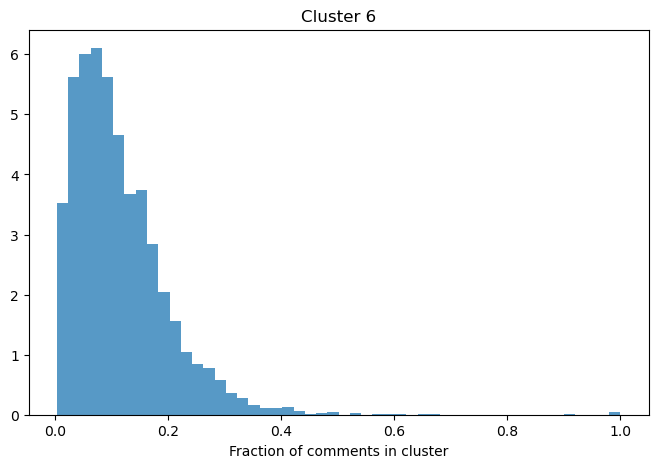

In [38]:
# cluster of interest
k = 6

# get the users with more than 50 total, and a non-zero count in cluster k
# tdf = user_clusters[user_clusters[k] > 0]
tdf = user_clusters[user_clusters[k] > 0]
tdf = tdf[tdf['total'] > 50]

# just keep column k
tdf = tdf[[k]]

# plot the distribution
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.hist(tdf[k], bins=50, density=True, alpha=0.75)
ax.set_xlabel('Fraction of comments in cluster')
ax.set_title(f'Cluster {k}')
plt.show()

/local/scr/stmorse/TMPDIR/ipykernel_170872/3039769015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['non_zero'] = (tdf > 0.1).sum(axis=1)


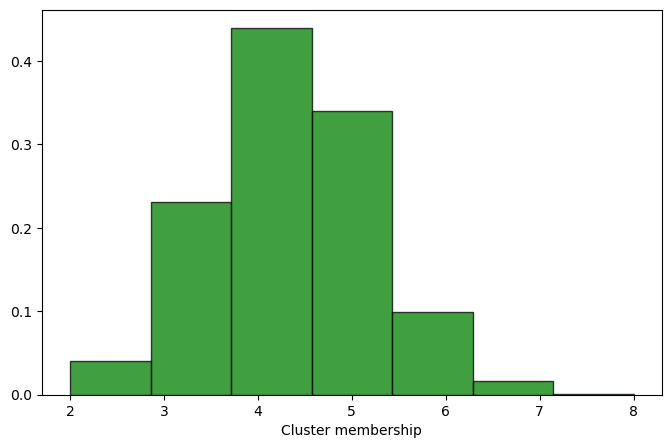

In [47]:
# get users with more than 50 comments
tdf = user_clusters[user_clusters['total'] > 50]

# create column with count of clusters with non-zero count
tdf['non_zero'] = (tdf > 0.1).sum(axis=1)

max_count = tdf['non_zero'].max()

tdf.head()

fig, ax = plt.subplots(1,1, figsize=(8, 5))

# plot the distribution of counts in the non-zero column
ax.hist(tdf['non_zero'], bins=max_count-1, color='green', ec='k', lw=1, density=True, alpha=0.75)

ax.set_xlabel('Cluster membership')
# ax.set_title(f'Cluster {k}')
plt.show()